In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import pyro

/home/aqoku/miniconda3/envs/cellij/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.set_default_tensor_type("torch.cuda.FloatTensor")

In [4]:
import muvi
import cellij
# from cellij.core.synthetic import DataGenerator
from muvi import DataGenerator
from cellij.core.models import MOFA

In [5]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: <object object at 0x7f63a043fb50>


In [6]:
# plotting functions
def _lines(ax, positions, ymin, ymax, horizontal=False, **kwargs):
    if horizontal:
        ax.hlines(positions, ymin, ymax, **kwargs)
    else:
        ax.vlines(positions, ymin, ymax, **kwargs)
    return ax


def lined_heatmap(data, figsize=None, hlines=None, vlines=None, **kwargs):
    """Plot heatmap with horizontal or vertical lines."""
    if figsize is None:
        figsize = (20, 2)
    fig, g = plt.subplots(figsize=figsize)
    g = sns.heatmap(data, ax=g, **kwargs)
    if hlines is not None:
        _lines(
            g,
            hlines,
            *sorted(g.get_xlim()),
            horizontal=True,
            lw=1.0,
            linestyles="dashed",
        )
    if vlines is not None:
        _lines(
            g,
            vlines,
            *sorted(g.get_ylim()),
            horizontal=False,
            lw=1.0,
            linestyles="dashed",
        )
    return g

In [7]:
# random seed to use throughout the notebook
seed = 123

# basic parameters
n_samples = 200
n_features = [400, 400, 400, 400]
n_views = len(n_features)
likelihoods = ["normal" for _ in range(n_views)]

# more specific parameters to the structure of the latent factors
n_fully_shared_factors = 20
n_partially_shared_factors = 0
n_private_factors = 0

# optional: number of covariates to generate
n_covariates = 0

In [8]:
dg = DataGenerator(
    n_samples,
    n_features,
    likelihoods,
    n_fully_shared_factors,
    n_partially_shared_factors,
    n_private_factors,
    n_covariates=n_covariates,
)

rng = dg.generate(seed=seed)

# center data
dg.normalise(with_std=False)

2023-05-04 17:24:16,211 - muvi.core.synthetic - WARNING - Using a uniform distribution with parameters 0.05 and 0.15 for generating the number of active factor loadings.


In [9]:
feature_offsets = [0] + np.cumsum(n_features).tolist()
vlines = feature_offsets[1:-1]

<Axes: >

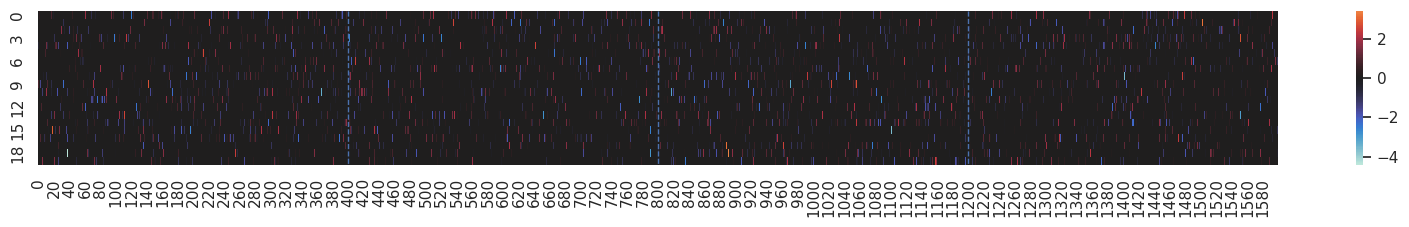

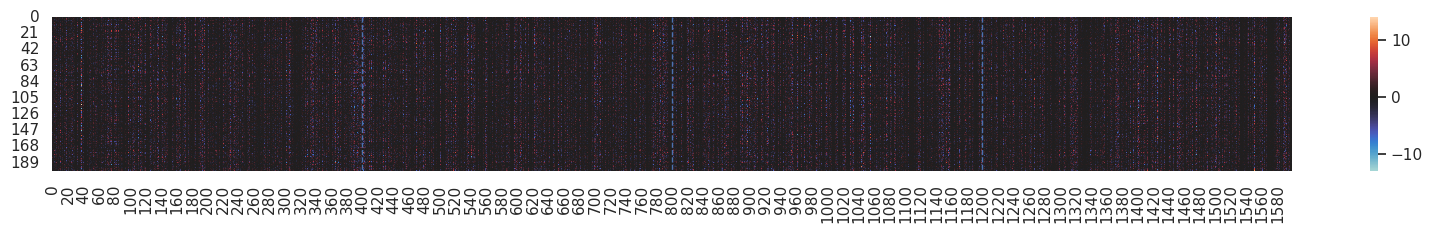

In [10]:
# factor loadings should be fairly sparse
lined_heatmap(dg.w, vlines=vlines, center=0)
lined_heatmap(dg.y, vlines=vlines, center=0)

In [11]:
mdata = dg.to_mdata()
mdata

MuData object with n_obs × n_vars = 200 × 1600
  obsm:	'z'
  4 modalities
    feature_group_0:	200 x 400
      varm:	'w', 'w_mask'
    feature_group_1:	200 x 400
      varm:	'w', 'w_mask'
    feature_group_2:	200 x 400
      varm:	'w', 'w_mask'
    feature_group_3:	200 x 400
      varm:	'w', 'w_mask'

In [12]:
# sparsity_prior="Horseshoe"
# # sparsity_prior="Lasso"
# # sparsity_prior="Spikeandslab-Lasso"
# model = MOFA(n_factors=dg.n_factors, sparsity_prior=sparsity_prior, guide="AutoNormal", init_scale=0.01)
# model.add_data(data=mdata, na_strategy=None)
# model._data._values = torch.Tensor(np.concatenate([mdata[key].X for key in mdata.mod.keys()], axis=1))

In [13]:
# model.fit(likelihoods=mdata.uns['likelihoods'],  epochs=10000, num_particles=20, learning_rate=0.01, verbose_epochs=500, min_delta=0.01)

In [14]:
# create an instance of the model
model = muvi.MuVI(
    dg.ys,
    n_factors=dg.n_factors,
    use_gpu=True,
)

2023-05-04 17:24:19,743 - muvi.core.models - WARNING - No view names provided!
2023-05-04 17:24:19,744 - muvi.core.models - INFO - Setting the name of each view to `view_idx` for list observations.
2023-05-04 17:24:19,745 - muvi.core.models - INFO - Setting the name of each sample to `sample_idx`.
2023-05-04 17:24:19,746 - muvi.core.models - INFO - Setting the name of each feature in `view_0` to `view_0_feature_idx`.
2023-05-04 17:24:19,747 - muvi.core.models - INFO - Setting the name of each feature in `view_1` to `view_1_feature_idx`.
2023-05-04 17:24:19,749 - muvi.core.models - INFO - Setting the name of each feature in `view_2` to `view_2_feature_idx`.
2023-05-04 17:24:19,750 - muvi.core.models - INFO - Setting the name of each feature in `view_3` to `view_3_feature_idx`.
2023-05-04 17:24:19,754 - muvi.core.models - INFO - Likelihoods set to `{'view_0': 'normal', 'view_1': 'normal', 'view_2': 'normal', 'view_3': 'normal'}`.
2023-05-04 17:24:22,934 - muvi.core.models - INFO - GPU av

In [15]:
n_epochs = 10000
model.fit(
    batch_size=n_samples,
    n_epochs=n_epochs,
    n_particles=20,
    learning_rate=0.01,
    optimizer="clipped",
    verbose=1,
    seed=seed,
    callbacks=[
        # log_callback,
        muvi.EarlyStoppingCallback(
            n_epochs, window_size=10, tolerance=1e-5, patience=10
        ),
    ],
)

2023-05-04 17:24:23,025 - muvi.core.models - INFO - Using 20 particles in parallel.
2023-05-04 17:24:23,027 - muvi.core.models - INFO - Preparing model and guide...
2023-05-04 17:24:23,028 - muvi.core.models - WARNING - No prior feature sets provided, running model uninformed.
2023-05-04 17:24:24,222 - muvi.core.models - INFO - Preparing optimizer...
2023-05-04 17:24:24,223 - muvi.core.models - INFO - Decaying learning rate over 10000 iterations.
2023-05-04 17:24:24,224 - muvi.core.models - INFO - Preparing SVI...
2023-05-04 17:24:24,225 - muvi.core.models - INFO - Preparing training data...
2023-05-04 17:24:24,228 - muvi.core.models - INFO - Using complete dataset.
2023-05-04 17:24:24,229 - muvi.core.models - INFO - Setting training seed to `123`.
2023-05-04 17:24:24,230 - muvi.core.models - INFO - Cleaning parameter store.
2023-05-04 17:24:24,231 - muvi.core.models - INFO - Starting training...


  0%|          | 0/10000 [00:00<?, ?it/s]

2023-05-04 17:24:24,833 - root - INFO - Guessed max_plate_nesting = 3


 34%|███▎      | 3360/10000 [02:30<04:56, 22.37it/s, ELBO=856]    

Relative improvement of -6.564e-05 < 1e-05 for 10 step(s) in a row, stopping early.
2023-05-04 17:26:54,422 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


In [ ]:
# model.data.values

In [ ]:
# np.concatenate([mdata[key].X for key in mdata.mod.keys()], axis=1)

In [ ]:
# model._guide.median().keys()

In [17]:
# z_hat = model._guide.median()['z']
# w_hat = model._guide.median()['unscaled_w'] * model._guide.median()['w_scale']

# z_hat = pyro.get_param_store().get_param('FactorModel._guide.locs.z')
# w_hat = pyro.get_param_store().get_param('FactorModel._guide.locs.w')
# sigma_hat = pyro.get_param_store().get_param('FactorModel._guide.locs.sigma')

# z_hat = model._guide.median()['z']
# w_hat = model._guide.median()['w']
# sigma_hat = model._guide.median()['sigma']

# z_hat = z_hat.detach().cpu().numpy().squeeze()
# w_hat = w_hat.detach().cpu().numpy().squeeze()

z_hat = model.get_factor_scores()
w_hat = np.concatenate([model.get_factor_loadings()[vn] for vn in model.view_names], axis=1)

x_hat = np.matmul(z_hat, w_hat)

# sigma_hat = sigma_hat.detach().cpu().numpy().squeeze()
print(z_hat.shape, w_hat.shape, x_hat.shape)


(200, 20) (20, 1600) (200, 1600)


<Axes: >

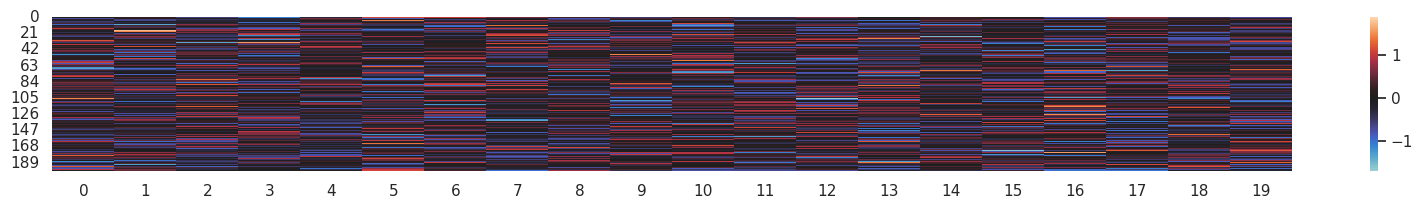

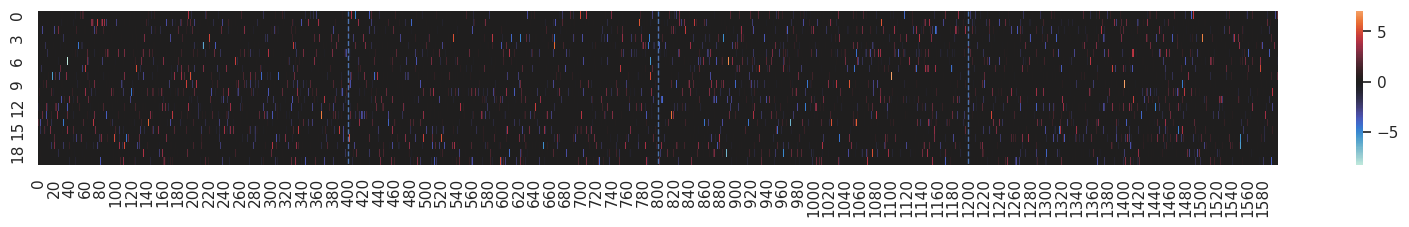

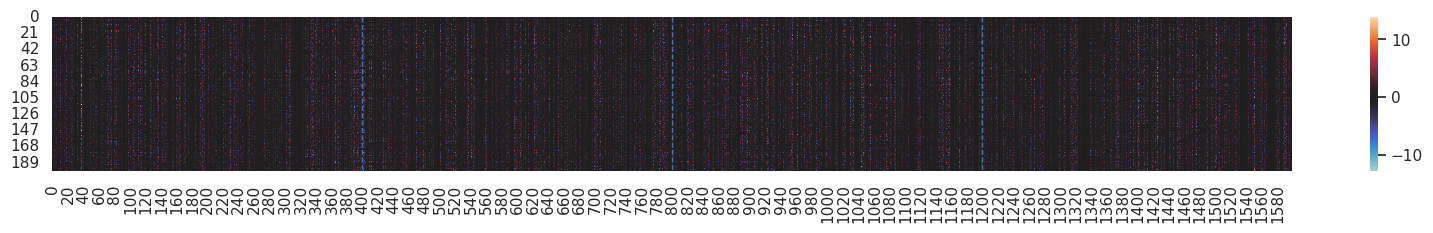

In [18]:

lined_heatmap(z_hat, vlines=vlines, center=0)
lined_heatmap(w_hat, vlines=vlines, center=0)
lined_heatmap(x_hat, vlines=vlines, center=0)
# lined_heatmap(sigma_hat[np.newaxis, :], vlines=vlines, center=0)

In [19]:
from scipy.optimize import linear_sum_assignment
from scipy.stats import pearsonr

from sklearn.metrics import pairwise_distances, mean_squared_error, r2_score
from sklearn.metrics import precision_recall_fscore_support, PrecisionRecallDisplay
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
r2_score(dg.y, x_hat)

0.7574664449227965

In [21]:
def get_opt_thresh(X, Y, thresh_min=0, thresh_max=1, n_thresh=101):
    thresh_max = min(thresh_max, Y.max())
    print(thresh_max)
    thresholds = np.linspace(thresh_min, thresh_max, n_thresh)
    f1s = []
    for threshold in thresholds:
        prec, rec, f1, _ = precision_recall_fscore_support(
            X.flatten(), (Y > threshold).flatten(), average="binary"
        )
        f1s.append(f1)

    return thresholds[np.argmax(f1s)]

In [22]:
opt_order = linear_sum_assignment(-np.abs(pairwise_distances(
    dg.w,
        w_hat,
        metric=lambda a, b: pearsonr(a, b)[0],
        force_all_finite=False,
    )))[-1]
opt_order

array([10,  3, 11, 16, 12,  4,  0, 19,  9, 14, 13,  1,  7, 17,  5,  8, 15,
       18,  6,  2])

In [23]:
# threshold = 0.1
# opt_order = muvi.tl.optim_perm(cosine_similarity(dg.w_mask, np.abs(w_hat) > threshold)).argmax(axis=0)
# opt_order

In [24]:
w_hat = w_hat[opt_order, :]
z_hat = z_hat[:, opt_order]

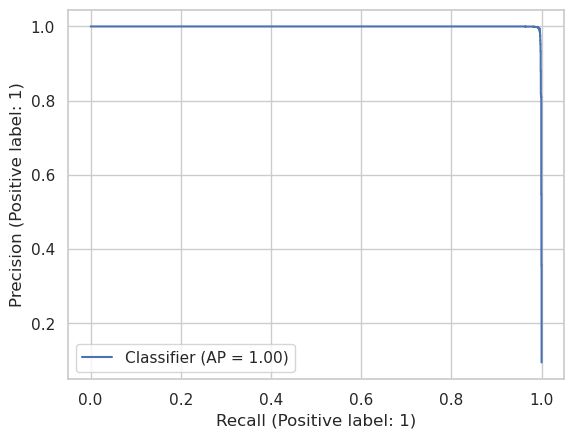

In [25]:
PrecisionRecallDisplay.from_predictions(dg.w_mask.flatten(), np.abs(w_hat).flatten())

In [26]:
threshold = get_opt_thresh(
    dg.w_mask,
    w_hat,
    0,
    5,
)
threshold

5


0.15000000000000002

<Axes: >

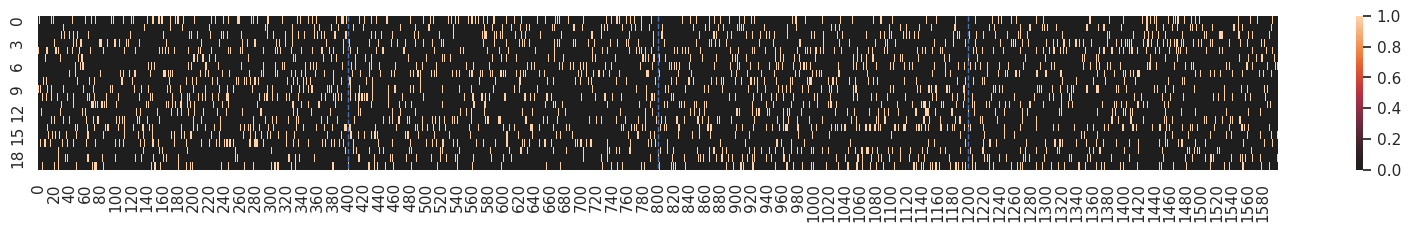

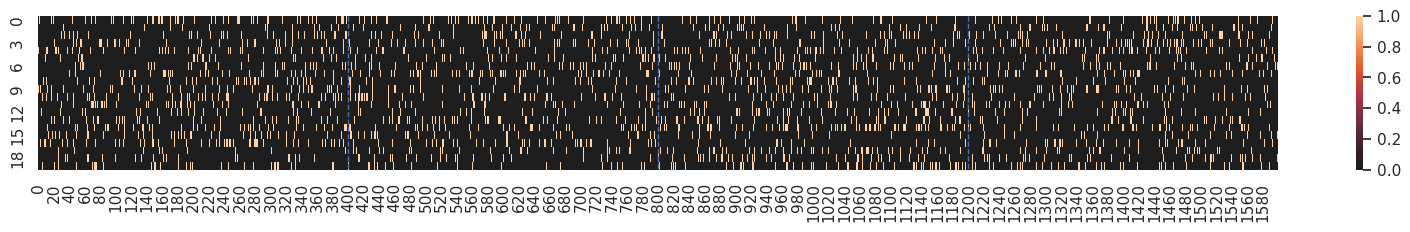

In [27]:
lined_heatmap(dg.w_mask, vlines=vlines, center=0)
lined_heatmap(np.abs(w_hat) > threshold, vlines=vlines, center=0)

In [28]:
precision_recall_fscore_support((dg.w_mask).flatten(), (np.abs(w_hat) > threshold).flatten(), average="binary")

(0.9888231426692965, 0.9960264900662251, 0.9924117452985813, None)

In [29]:
# pyro.get_param_store().save("params.save")
# pyro.get_param_store().load("params.save", map_location='cpu')